In [1]:
import pandas as pd
import numpy as np
import copy
import re
import operator
from tqdm import tqdm
from collections import Counter

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
train_data = pd.read_csv("../data/raw/train_data_restaurant.tsv",sep="\t",header = None)
train_data.columns = ["review","sentiment"]

test_dataset = pd.read_csv("../data/raw/test_data_restaurant.tsv",sep="\t",header = None)
test_dataset.columns = ["review","sentiment"]

In [3]:
train_data.head()

review sentiment
0  Saya makan di sini dengan menggunakan voucher ...  negative
1  Mas indosat buat main game enemy has been slai...  negative
2  Trus sy percuma dong update no hp terbaru ke c...  negative
3  jika kita pilih dia maka akan ada lebih dari 3...  negative
4  Dikarenakan adik saya suka dengan restoran ini...  negative

In [4]:
Counter(train_data["sentiment"])

Counter({'negative': 580, 'positive': 1200})

**Found 1: There are 1780 reviews, and imbalanced dataset with 580 negatives, and 1200 positives**

In [5]:
for _ in range(5):
    print(train_data["review"][np.random.randint(0, len(train_data["review"]))])

Salah satu cabang Giggle Box di Bandung. Ciri khasnya sama : tempat nongkrong nyaman, ada smoking area, menu makanan bermacam, harganya pun sesuai. Wajib dicoba : Ice Thai Tea nya, juara!
Ramen yang ditawarkan di sini melebihi ekspektasi saya sebelumnya, rasanya sangat enak dibanding ramen lainnya di kota Bandung. Harga yang dipatok juga cukup masuk akal untuk rasa ramen yang juara.
Untuk makan disini memang enak dengan keluarga, teman, dan rekan kerja Masakan nya enak, Banyak varian, dengan cita rasa indonesia
Restauran medium size sedikit kelihatan tua makanan variasi untuk padang ok makanan ya standar sekali tidak ada karakter yang kuat yang menonjol dan cukup baik bersama keluarga terutama sore hari
Udara dingin bandung enak dinikmati dengan sajian ramen, mungkin karen kondisi di pusat kota yang tidak memungkinkan untuk outdoor sehingga penyajiannya sama seperti restoran lainnya. Cukup enak dan memberi penglaman baru


**Found 2: Spotted: Slang word, abbreviation, informal words**<br />
ex: 
> 1. 33rb
> 2. 2x
> 3. mba2

In [6]:
length_of_text = [len(i) for i in train_data["review"]]
train_data["length_of_text"] = length_of_text
describe_the_data = train_data.groupby("sentiment").describe()
describe_the_data

length_of_text                                                       \
                   count        mean         std   min     25%    50%     75%   
sentiment                                                                       
negative           580.0  273.253448  104.213874  65.0  174.75  289.0  366.00   
positive          1200.0  238.435000  100.969508  51.0  152.00  214.5  329.25   

                  
             max  
sentiment         
negative   538.0  
positive   504.0

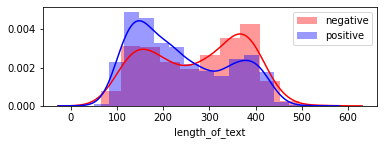

In [7]:
plt.subplot(2,1,1)
sns.distplot(train_data["length_of_text"].loc[train_data["sentiment"]=="negative"],color="red", label = "negative")
sns.distplot(train_data["length_of_text"].loc[train_data["sentiment"]=="positive"],color = "blue", label= "positive")
plt.legend()
plt.show()

**Found 3: Positive reviews kinda have shorter length of text, compared to negative**

In [8]:
def preprocessing(text):
    text = text.lower()
    
    dicts = {' ad ':' ada ',' dgn ':' dengan ',
             ' g ':' engga ' ,' ga ':' engga ',
             ' jd ':' jadi ', ' jg ':' juga ',
             ' lg ':' lagi ', ' mw ':' mau ',
             ' pd ':' pada ',' sy ':' saya ',
             ' yg ':' yang '}
    for i in dicts:
        text = text.replace(i, dicts[i])
    
    #remove the ., in number (8.000.000->8000000) 
    text = re.sub(r"([0-9]+)([.,])([0-9]+)([.,])([0-9]+)", r"\1\3\5", text)
    text = re.sub(r"([0-9]+)([.,])([0-9]+)", r"\1\3", text)
    
    #Remove the repetition in word (mahalll -> mahal)
    text = re.sub(r"([A-z])(\1{2,})",r"\1",text)
    
    #Convert the '2' in repetition word (mbak2 -> mbak-mbak)
    text = re.sub(r"([A-z]+)([2])",r"\1-\1", text)
    
    #Stemming -nya (capcaynya -> capcay nya)
    text = re.sub(r"([A-z]{3,})(nya)( |[.,!])",r"\1 \2 ", text)
    
    text = re.sub(r"(.)(\()(.)", r"\1 \2 \3", text)
    text = re.sub(r"(.)(\))(.)", r"\1 \2 \3", text)

    #Seperate the punctuation and word
    text = re.sub(r"([ A-z0-9]*)([^A-z0-9 ]*)",r"\1 \2",text)
    text = re.sub(r"([^A-z0-9 ]*)([ A-z0-9]*)",r"\1 \2",text)
    
    #Convert the multiple punct (!!!!! -> MultiExclamation)
    text = re.sub(r"(\!)\1+", " MultiExclamation", text)
    text = re.sub(r"(\?)\1+", " MultiQuestion", text)
    text = re.sub(r"(\.)\1+", " MultiStop", text)
    text = re.sub(r"(\,)\1+", " MultiComma", text)

    #split the punctuation (!&@ -> ! & @)
    text = re.sub(r"([^A-z0-9])(\1*)",r"\1 ",text)
    
    #Remove the number in the text (12000 -> #####)
    text = re.sub(r"([0-9])",r"#",text)

    #Trim the multi white space
    text = re.sub(r"(\s)(\1*)",r"\1",text)
    return text.strip()

In [9]:
preprocessed_text = [preprocessing(i) for i in train_data["review"]]

In [10]:
train_data["preprocessed_data"] = preprocessed_text
length_of_text = [len(i) for i in train_data["preprocessed_data"]]
train_data["length_of_preprocessed_text"] = length_of_text
describe_the_data = train_data.groupby("sentiment").describe()
describe_the_data

length_of_text                                                       \
                   count        mean         std   min     25%    50%     75%   
sentiment                                                                       
negative           580.0  273.253448  104.213874  65.0  174.75  289.0  366.00   
positive          1200.0  238.435000  100.969508  51.0  152.00  214.5  329.25   

                 length_of_preprocessed_text                                \
             max                       count        mean         std   min   
sentiment                                                                    
negative   538.0                       580.0  285.231034  108.711618  69.0   
positive   504.0                      1200.0  247.910833  104.406322  51.0   

                                       
             25%    50%    75%    max  
sentiment                              
negative   181.0  299.5  381.0  559.0  
positive   157.0  223.0  341.0  532.0

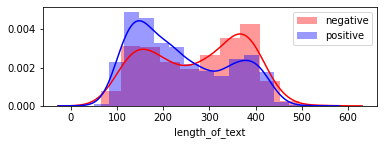

In [11]:
plt.subplot(2,1,1)
sns.distplot(train_data["length_of_text"].loc[train_data["sentiment"]=="negative"],color="red", label = "negative")
sns.distplot(train_data["length_of_text"].loc[train_data["sentiment"]=="positive"],color = "blue", label= "positive")
plt.legend()
plt.show()

still with same distribution shape

In [12]:
text = train_data["review"]

In [13]:
def create_counter_dataframe(texts):
    temp_df = pd.DataFrame(Counter([j for i in texts for j in i.split()]).items(), columns = ["word", "count"]).sort_values(by = "count", ascending = False)
    return temp_df

In [14]:
word_count_preprocessed_text = create_counter_dataframe(preprocessed_text)
word_count_text = create_counter_dataframe(text)

In [15]:
all_pre_top_20 = word_count_preprocessed_text[:20].values[:,0]
all_plain_top_20 = word_count_text[:20].values[:,0]
print("preprocessed == ", all_pre_top_20)
print("plain == ", all_plain_top_20)

preprocessed ==  ['.' 'nya' ',' 'yang' 'dan' 'di' 'saya' 'enak' 'dengan' 'tempat' 'makanan'
 'untuk' 'ini' '-' 'rasa' 'makan' 'tidak' 'juga' 'ada' 'harga']
plain ==  ['dan' 'yang' 'di' 'saya' 'dengan' 'untuk' 'tidak' 'makan' 'ini' 'makanan'
 'juga' 'ada' 'yg' 'tempat' 'enak' 'nya' 'sangat' 'ke' 'cukup' 'dari']


*Let's see the distribution of counter*

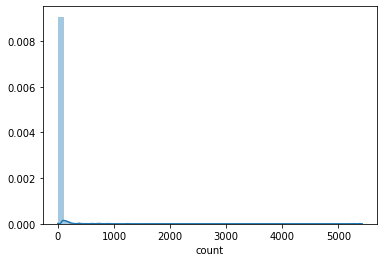

In [16]:
sns.distplot(word_count_preprocessed_text["count"])

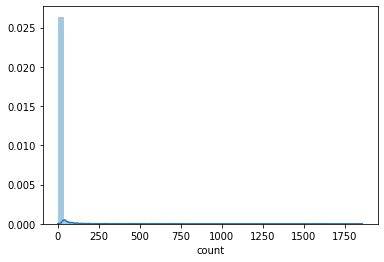

In [17]:
sns.distplot(word_count_text["count"])

*Most of the word is likely unique (count = 1)*

In [18]:
positive_sent = train_data[train_data["sentiment"] == "positive"]
negative_sent = train_data[train_data["sentiment"] == "negative"]

In [19]:
word_count_preprocessed_text = create_counter_dataframe(positive_sent["preprocessed_data"])
word_count_text = create_counter_dataframe(positive_sent["review"])

In [21]:
pos_pre_top_20 = word_count_preprocessed_text[:20].values[:,0]
pos_plain_top_20 = word_count_text[:20].values[:,0]
print("preprocessed == ", pos_pre_top_20)
print("plain == ", pos_plain_top_20)

preprocessed ==  ['.' 'nya' ',' 'yang' 'dan' 'di' 'enak' 'saya' 'dengan' 'tempat' 'ini'
 'untuk' 'makanan' 'juga' '-' 'makan' 'rasa' 'harga' 'menu' 'ada']
plain ==  ['dan' 'yang' 'di' 'dengan' 'saya' 'untuk' 'ini' 'juga' 'makan' 'enak'
 'tempat' 'nya' 'makanan' 'cukup' 'sangat' 'ada' 'tidak' 'yg' 'menu' 'ke']


In [22]:
word_count_preprocessed_text = create_counter_dataframe(negative_sent["preprocessed_data"])
word_count_text = create_counter_dataframe(negative_sent["review"])

In [23]:
neg_pre_top_20 = word_count_preprocessed_text[:20].values[:,0]
neg_plain_top_20 = word_count_text[:20].values[:,0]
print("preprocessed == ", neg_pre_top_20)
print("plain == ", neg_plain_top_20)

preprocessed ==  ['.' 'nya' ',' 'yang' 'dan' 'saya' 'di' 'tidak' 'makanan' 'dengan' '-'
 'rasa' 'untuk' 'ada' 'tempat' 'kami' 'makan' 'ini' '#' 'enak']
plain ==  ['dan' 'di' 'yang' 'saya' 'tidak' 'yg' 'dengan' 'untuk' 'ada' 'makanan'
 'makan' 'kami' 'ke' 'tempat' 'ini' 'kurang' 'sangat' 'tapi' 'dari'
 'karena']


**We have to remove those words that appears on that 6 lists, because likely it's a stopwords.**

In [24]:
tmp = set()
for i in all_pre_top_20:
    tmp.add(i)
for i in all_plain_top_20:
    tmp.add(i)
for i in pos_pre_top_20:
    tmp.add(i)
for i in pos_plain_top_20:
    tmp.add(i)
for i in neg_pre_top_20:
    tmp.add(i)
for i in neg_plain_top_20:
    tmp.add(i)

In [25]:
stopwords = []
for i in tmp:
    if((i in all_pre_top_20) & (i in all_plain_top_20)& (i in pos_pre_top_20)& (i in pos_plain_top_20)& (i in neg_pre_top_20)& (i in neg_plain_top_20)):
        stopwords.append(i)

In [26]:
print("stopwords:", stopwords)

stopwords: ['ada', 'yang', 'dan', 'saya', 'ini', 'makanan', 'untuk', 'tempat', 'dengan', 'makan', 'di']


In [31]:
#Save the stopwords:
import pickle
pickle.dump(stopwords,open("../data/clean/stopwords.pkl","wb"))

In [32]:
def remove_stopwords(x):
    return " ".join([y for y in x.split() if y not in stopwords])

In [33]:
#Example
idx = np.random.randint(0, len(preprocessed_text))
print(preprocessed_text[idx])
print(remove_stopwords(preprocessed_text[idx]))

menu chinese food lumayan lengkap hanya porsi kecil , untuk makanan di sini lebih baik beli yang sudah satu paket nasi dan sayiuran dalam mangkok
menu chinese food lumayan lengkap hanya porsi kecil , sini lebih baik beli sudah satu paket nasi sayiuran dalam mangkok


**Removed the stopwords in the preprocessed_text**

In [34]:
preprocessed_text = [remove_stopwords(i) for i in preprocessed_text]

(array([ 21., 231., 382., 292., 245., 210., 247., 122.,  26.,   4.]),
 array([ 5. , 13.5, 22. , 30.5, 39. , 47.5, 56. , 64.5, 73. , 81.5, 90. ]),
 <a list of 10 Patch objects>)

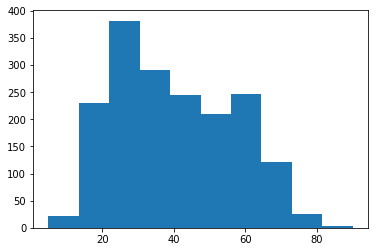

In [35]:
lengths = [len(i.split()) for i in preprocessed_text]
plt.hist(lengths)

**Since there are still a few text that is more than 80 words per text, then we will use 100 for MAX_LEN for the next modelling step**

In [36]:
test_dataset["review"] = test_dataset["review"].apply(lambda x: remove_stopwords(preprocessing(x)))

In [37]:
test_dataset.to_csv("../data/clean/test_dataset.csv")

In [38]:
train_data[["preprocessed_data", "sentiment"]].to_csv("../data/clean/train_dataset.csv")